# CS180 (CS280A): Project 1
## Import and Loading Data

In [329]:
# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
import time

name_img = "icon"

# name of the input file
imname = f'./Pics/{name_img}.tif'

# read in the image
im = skio.imread(imname)

# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)
    
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

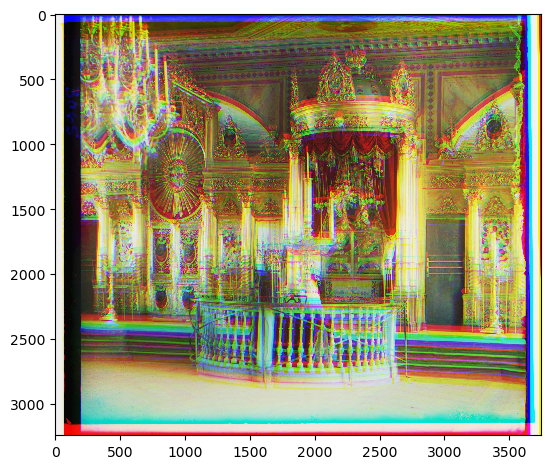

In [330]:
# show the initial picture
im_init = np.dstack([r, g, b])

im_init_jpg = sk.img_as_ubyte(im_init)

# save the image
fname = f'./to_deliver/{name_img}init.jpg'
skio.imsave(fname, im_init_jpg)


# display the image
skio.imshow(im_init)

## Cropping Sides

In [331]:
# detect standard deviation of each row/ column of each color channel
# if the sd is too low, identify it as all white/black and crop the side

threshold = 0.2

r_sd = np.std(r, axis=1)
g_sd = np.std(g, axis=1)
b_sd = np.std(b, axis=1)
lower_bound_r = np.where(r_sd > threshold)[0][0]
lower_bound_g = np.where(g_sd > threshold)[0][0]
lower_bound_b = np.where(b_sd > threshold)[0][0]

upper_bound_r = np.where(r_sd > threshold)[0][-1]
upper_bound_g = np.where(g_sd > threshold)[0][-1]
upper_bound_b = np.where(b_sd > threshold)[0][-1]

row_range = [min(lower_bound_b,lower_bound_g,lower_bound_r),
             max(upper_bound_r,upper_bound_g,upper_bound_b)]

r_sd = np.std(r, axis=0)
g_sd = np.std(g, axis=0)
b_sd = np.std(b, axis=0)
lower_bound_r = np.where(r_sd > threshold)[0][0]
lower_bound_g = np.where(g_sd > threshold)[0][0]
lower_bound_b = np.where(b_sd > threshold)[0][0]

upper_bound_r = np.where(r_sd > threshold)[0][-1]
upper_bound_g = np.where(g_sd > threshold)[0][-1]
upper_bound_b = np.where(b_sd > threshold)[0][-1]

col_range = [min(lower_bound_b,lower_bound_g,lower_bound_r),
             max(upper_bound_r,upper_bound_g,upper_bound_b)]

r = r[row_range[0]:row_range[1], col_range[0]:col_range[1]]
g = g[row_range[0]:row_range[1], col_range[0]:col_range[1]]
b = b[row_range[0]:row_range[1], col_range[0]:col_range[1]]

## Basic Alignment Function

In [332]:
# helper function that search for horizontal and vertical movement within a margin
# that generates best NCC between two matrices
def align(x,y, margin = 10):

    best_NCC, best_i, best_j = -1,-1,-1
    v_adjust = h_adjust = margin

    for i in range(-v_adjust,v_adjust+1):
        for j in range(-h_adjust,h_adjust+1):
            rolled_x = np.roll(x,(i,j), axis = (0,1))
            cur_NCC = np.sum((rolled_x/np.linalg.norm(rolled_x)) * (y/np.linalg.norm(y)))
            if cur_NCC > best_NCC:
                best_i, best_j, best_NCC = i,j,cur_NCC

    return best_i, best_j

## Image Pyramid

In [333]:
# helper function that applies a gaussian blur to a matrix 
# before down scaling it, helps anti aliasing
# uses default kernel of [1,2,1][2,4,2][1,2,1]/16
def gaussian_blur(x, kernel = np.array([[1,2,1],
                                        [2,4,2],
                                        [1,2,1]])/16):
    padding = kernel.shape[0]//2
    padded_x = np.pad(x,padding)

    toReturn = np.zeros(x.shape)

    for i in range(toReturn.shape[0]):
        for j in range(toReturn.shape[1]):
            toReturn[i,j] = np.sum(padded_x[i:i+padding+2, 
                                            j:j+padding+2]*kernel)
    
    return toReturn

In [334]:
# function that take input of a list containing one element: the full size image and 
# fill the list with downsized image to desired depth

def generate_pyramid(pyramid_base, size = 4):
    if size != 1:
        last_layer = pyramid_base[-1]
        blurred_layer = np.dstack([gaussian_blur(last_layer[:,:,0]), 
                                   gaussian_blur(last_layer[:,:,1]), 
                                   gaussian_blur(last_layer[:,:,2])])
        dsed_layer = blurred_layer[0:-1:2,0:-1:2,:]
        pyramid_base.append(dsed_layer)
        generate_pyramid(pyramid_base, size-1)

    return pyramid_base

In [335]:
# function that finds desired movement using image pyramid,
# find displacement at bottom (smallest image) and pipeline into the above level
# eventually find the needed displacement at top level (original image)

def find_movement(pyramid):
    r_v, r_h = 0, 0
    g_v, g_h = 0, 0
    for i in range(len(pyramid)):
        r_v_i, r_h_i = align(np.roll(pyramid[-i-1][:,:,0], (r_v,r_h),axis = (0,1)), 
                             pyramid[-i-1][:,:,2], 
                             20-5*i)
        g_v_i, g_h_i = align(np.roll(pyramid[-i-1][:,:,1], (g_v,g_h),axis = (0,1)), 
                             pyramid[-i-1][:,:,2], 
                             20-5*i)
        r_v += r_v_i; r_h += r_h_i
        g_v += g_v_i; g_h += g_h_i
        if i != len(pyramid)-1:
            r_v *= 2; r_h *= 2
            g_v *= 2; g_h *= 2
    return [[r_v,r_h],[g_v,g_h]]

## Alignment

In [336]:
start_time = time.time()

pyramid = generate_pyramid([np.dstack([r, g, b])])
movement = find_movement(pyramid)

# the aligned red/green matrix, calculated using the desired movement generated above

ar = np.roll(r, (movement[0][0],movement[0][1]), axis = (0,1))
ag = np.roll(g, (movement[1][0],movement[1][1]), axis = (0,1))

end_time = time.time()
execution_time = end_time - start_time
print("It took ", execution_time, "seconds to do the alignment")

It took  174.74988794326782 seconds to do the alignment


In [337]:
print(movement)

[[90, 22], [40, 16]]


## Post-Process

### Balance Intensity

In [338]:
r_b = (np.mean(pyramid[0][:,:,0])) - (np.mean(pyramid[0][:,:,2]))
g_b = (np.mean(pyramid[0][:,:,1])) - (np.mean(pyramid[0][:,:,2]))
ar = ar - r_b
ag = ag - g_b

### Color Contrasting

In [339]:

if ar.min() != 0 or ar.max() != 1:
    ar = (ar-ar.min())/(ar.max()-ar.min())
if ag.min() != 0 or ag.max() != 1:
    ag = (ag-ag.min())/(ag.max()-ag.min())
if b.min() != 0 or b.max() != 1:
    b = (b-b.min())/(b.max()-b.min())    

## Final Output

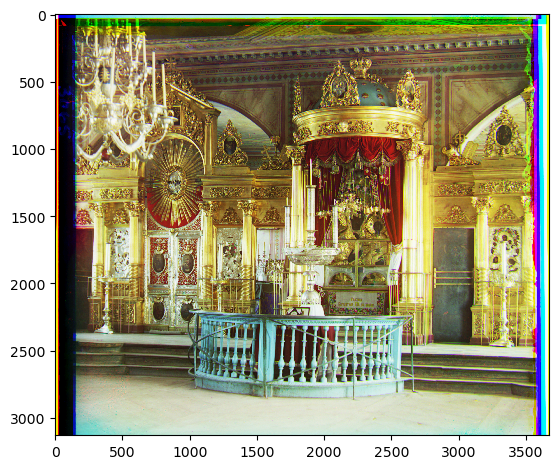

In [340]:
im_out = np.dstack([ar, ag, b])

im_out_jpg = sk.img_as_ubyte(im_out)

# save the image
fname = f'./to_deliver/{name_img}.jpg'
skio.imsave(fname, im_out_jpg)

# display the image
skio.imshow(im_out)
skio.show()